In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image
import pandas as pd
import os
import pickle

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(
        original, reconstructed, data_range=original.max() - original.min()
    )
    return mse_value, psnr_value

# Load image
image_url = "1.jpg"  # Ensure '1.jpg' is in the current working directory
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

# Resize image to 256x256
image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((128, 128)))

# Display the original image
plt.figure(figsize=(6, 4))
if image_original.dtype in [np.float32, np.float64]:
    plt.imshow(image_original / 255.0)
else:
    plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Normalize image to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define auxiliary functions
def generate_random_directions(num_directions):
    # Generate the first random angle
    theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)

    # Compute angle increment
    delta_theta = 2 * np.pi / num_directions

    # Generate the angles starting from theta0
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0

    # Wrap angles back into [0, 2π)
    angles = angles % (2 * np.pi)

    # Compute directions
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py_grid, Px_grid = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px_flat = Px_grid.flatten()
    Py_flat = Py_grid.flatten()
    coordinates = calculate_coordinates(Px_flat, Py_flat, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Analysis parameters
num_directions_list = [1,2,4,8,16,32,50,100, 200, 400, 800, 1600,3200,6400,12800]  # Different number of directions to test
num_iterations_list = [5,10, 20, 40, 80, 160,320,640,1280]  # Different number of iterations to test
# num_directions_list = [50,100]  # Different number of directions to test
# num_iterations_list = [5,10]  # Different number of iterations to test
# Threshold to limit computational load
# num_directions_list = [4,64]  # Different number of directions to test
# num_iterations_list = [880]  # Different number of iterations to test
threshold = 51921

# 初始化列表以存储结果
results_list = []

# 循环遍历不同的组合
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # 生成随机方向
        if (num_directions) * (num_iterations*10) > threshold:
            print(f"Skipping: Directions={num_directions}, Iterations={num_iterations} (Threshold exceeded)")
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py_grid, Px_grid = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px_grid.flatten()
        Py = Py_grid.flatten()

        for t in tqdm(range(num_iterations), desc=f"Directions={num_directions}, Iter={num_iterations}"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_lerp(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

        # 重建预测图像（平均）
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # 评估指标
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)

        # 使用最小二乘法优化的预测图像
        # 为最小二乘问题采样一部分像素
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # 初始化X矩阵用于最小二乘法
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_lerp(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # 解决每个通道的最小二乘问题
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # 使用优化权重重建最终预测图像
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # 优化后的评估指标
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)

        # 差异图像（Optimized - Original）
        difference_image = np.abs(reconstructed2_opt - image)

        # 计算采样点数量
        sample_points = num_iterations * 10

        # 将结果添加到列表中
        results_list.append({
            'num_directions': num_directions,
            'sample_points': sample_points,
            'MSE_Average': mse2_avg,
            'PSNR_Average': psnr2_avg,
            'MSE_Optimized': mse2_opt,
            'PSNR_Optimized': psnr2_opt
        })

        # 打印进度
        print(f"Completed: Directions={num_directions}, Sample Points={sample_points}")

        # 显示结果图像
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 平均预测图像
        avg_image_display = final_predicted_image_avg.cpu().numpy() / 255.0
        axes[0].imshow(avg_image_display)
        axes[0].set_title(f'Average Predicted Image (Directions={num_directions}, Sample Points={sample_points})\nPSNR: {psnr2_avg:.2f}dB, MSE: {mse2_avg:.6f}')
        axes[0].axis('off')

        # 优化预测图像
        axes[1].imshow(reconstructed2_opt)
        axes[1].set_title(f'Optimized Predicted Image (Directions={num_directions}, Sample Points={sample_points})\nPSNR: {psnr2_opt:.2f}dB, MSE: {mse2_opt:.6f}')
        axes[1].axis('off')

        # 差异图像
        axes[2].imshow(difference_image, cmap='gray')
        axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        axes[2].set_title('Difference Image (Optimized - Original)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        # 创建DataFrame
        results = pd.DataFrame(results_list)

        # 显示DataFrame
        print(results)

        # 可选：将结果保存为CSV文件以供将来参考
        results.to_csv('reconstruction_results.csv', index=False)

# 创建DataFrame
results = pd.DataFrame(results_list)

# 显示DataFrame
print(results)

# 可选：将结果保存为CSV文件以供将来参考
results.to_csv('reconstruction_results.csv', index=False)

# # 3D 散点图
# fig = plt.figure(figsize=(20, 10))

# # MSE (Average) 的3D散点图
# ax1 = fig.add_subplot(2, 2, 1, projection='3d')
# scatter1 = ax1.scatter(
#     results['num_directions'],
#     results['sample_points'],
#     results['MSE_Average'],
#     c=results['MSE_Average'],
#     cmap='viridis',
#     s=100,
#     depthshade=True
# )
# ax1.set_title('MSE (Average) across Directions and Sample Points')
# ax1.set_xlabel('Number of Directions')
# ax1.set_ylabel('Sample Points')
# ax1.set_zlabel('MSE')
# fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=10)

# # PSNR (Average) 的3D散点图
# ax2 = fig.add_subplot(2, 2, 2, projection='3d')
# scatter2 = ax2.scatter(
#     results['num_directions'],
#     results['sample_points'],
#     results['PSNR_Average'],
#     c=results['PSNR_Average'],
#     cmap='plasma',
#     s=100,
#     depthshade=True
# )
# ax2.set_title('PSNR (Average) across Directions and Sample Points')
# ax2.set_xlabel('Number of Directions')
# ax2.set_ylabel('Sample Points')
# ax2.set_zlabel('PSNR (dB)')
# fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=10)

# # MSE (Optimized) 的3D散点图
# ax3 = fig.add_subplot(2, 2, 3, projection='3d')
# scatter3 = ax3.scatter(
#     results['num_directions'],
#     results['sample_points'],
#     results['MSE_Optimized'],
#     c=results['MSE_Optimized'],
#     cmap='inferno',
#     s=100,
#     depthshade=True
# )
# ax3.set_title('MSE (Optimized) across Directions and Sample Points')
# ax3.set_xlabel('Number of Directions')
# ax3.set_ylabel('Sample Points')
# ax3.set_zlabel('MSE')
# fig.colorbar(scatter3, ax=ax3, shrink=0.5, aspect=10)

# # PSNR (Optimized) 的3D散点图
# ax4 = fig.add_subplot(2, 2, 4, projection='3d')
# scatter4 = ax4.scatter(
#     results['num_directions'],
#     results['sample_points'],
#     results['PSNR_Optimized'],
#     c=results['PSNR_Optimized'],
#     cmap='cividis',
#     s=100,
#     depthshade=True
# )
# ax4.set_title('PSNR (Optimized) across Directions and Sample Points')
# ax4.set_xlabel('Number of Directions')
# ax4.set_ylabel('Sample Points')
# ax4.set_zlabel('PSNR (dB)')
# fig.colorbar(scatter4, ax=ax4, shrink=0.5, aspect=10)

# plt.tight_layout()
# plt.show()

# 可选：3D 表面图示例（需要数据为完整网格）
# 这里假设您的 num_iterations 和 num_directions 组合形成了完整的网格
# 如果不是，请确保数据完整或进行适当的插值

# 创建透视表以适应表面图
pivot_table = results.pivot(index='sample_points', columns='num_directions', values='MSE_Average')

# 检查是否有缺失值
if pivot_table.isnull().values.any():
    print("Warning: Pivot table contains NaN values. Surface plot may be incomplete.")

# 创建网格
X = pivot_table.columns.values
Y = pivot_table.index.values
X, Y = np.meshgrid(X, Y)
Z = pivot_table.values

# 绘制MSE (Average) 的表面图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('MSE (Average) Surface Plot')
ax.set_xlabel('Number of Directions')
ax.set_ylabel('Sample Points')
ax.set_zlabel('MSE')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns


results['parameter_count'] = results['num_directions']  * results['sample_points']*4
results['parameter_count_compressed'] = results['sample_points']*5
# Set the plotting style
sns.set(style="whitegrid")

# Get sorted unique sample points for consistent coloring
sample_points = sorted(results['sample_points'].unique())

# Create a color palette
palette = sns.color_palette("hsv", len(sample_points))

# Plot 1: MSE_Average vs. Parameter Count
plt.figure(figsize=(12, 8))

for idx, samp_pt in enumerate(sample_points):
    subset = results[results['sample_points'] == samp_pt]
    subset = subset.sort_values('parameter_count')
    plt.plot(
        subset['parameter_count'],
        subset['MSE_Average'],
        marker='o',
        label=f'Sample Points = {samp_pt}',
        color=palette[idx]
    )

plt.xlabel('Number of Parameters (Directions  * Sample Points * 4)', fontsize=14)
plt.ylabel('MSE (Mean Squared Error - Average)', fontsize=14)
plt.title('Relationship Between Parameter Count and Average MSE', fontsize=16)
plt.legend(title='Sample Points', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for idx, samp_pt in enumerate(sample_points):
    subset = results[results['sample_points'] == samp_pt]
    subset = subset.sort_values('parameter_count')
    plt.plot(
        subset['parameter_count'],
        subset['MSE_Average'],
        marker='o',
        label=f'Sample Points = {samp_pt}',
        color=palette[idx]
    )

plt.xlabel('Number of Parameters (Directions  * Sample Points * 4)', fontsize=14)
plt.ylabel('MSE (Mean Squared Error - Average)', fontsize=14)
plt.title('Relationship Between Parameter Count and Average MSE', fontsize=16)
plt.legend(title='Sample Points', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: MSE_Optimized vs. Parameter Count
plt.figure(figsize=(12, 8))

for idx, samp_pt in enumerate(sample_points):
    subset = results[results['sample_points'] == samp_pt]
    subset = subset.sort_values('parameter_count')
    plt.plot(
        subset['parameter_count'],
        subset['MSE_Optimized'],
        marker='x',
        label=f'Sample Points = {samp_pt}',
        color=palette[idx]
    )

plt.xlabel('Number of Parameters (Directions  * Sample Points * 4)', fontsize=14)
plt.ylabel('MSE (Mean Squared Error - Optimized)', fontsize=14)
plt.title('Relationship Between Parameter Count and Optimized MSE', fontsize=16)
plt.legend(title='Sample Points', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot 1: MSE_Average vs. Parameter Count
plt.figure(figsize=(12, 8))

for idx, samp_pt in enumerate(sample_points):
    subset = results[results['sample_points'] == samp_pt]
    subset = subset.sort_values('parameter_count_compressed')
    plt.plot(
        subset['parameter_count_compressed'],
        subset['MSE_Average'],
        marker='o',
        label=f'Sample Points = {samp_pt}',
        color=palette[idx]
    )

plt.xlabel('Number of Parameters (Compressed)', fontsize=14)
plt.ylabel('MSE (Mean Squared Error - Average)', fontsize=14)
plt.title('Relationship Between Parameter Count and Average MSE', fontsize=16)
plt.legend(title='Sample Points', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: MSE_Optimized vs. Parameter Count
# Plot 2: MSE_Optimized vs. Parameter Count
plt.figure(figsize=(12, 8))
directions = sorted(results['num_directions'].unique())
for idx, samp_d in enumerate(directions):
    subset = results[results['num_directions'] == samp_d]
    subset = subset.sort_values('parameter_count_compressed')
    plt.plot(
        subset['parameter_count_compressed'],
        subset['MSE_Optimized'],
        marker='x',
        label=f'Directions = {samp_d}',
        color=palette[idx]
    )

plt.xlabel('Number of Parameters (Compressed)', fontsize=14)
plt.ylabel('MSE (Mean Squared Error - Optimized)', fontsize=14)
plt.title('Relationship Between Parameter Count and Optimized MSE', fontsize=16)
plt.legend(title='Sample Points', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Device in use: cuda
Original image shape: (1024, 1024, 3) Type: uint8


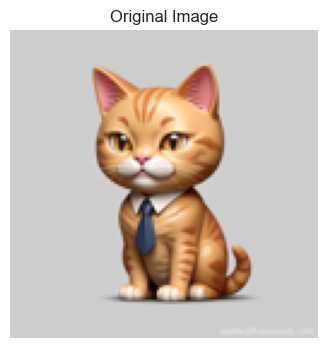

Directions=1, Iter=5: 100%|██████████| 5/5 [00:00<00:00, 263.38it/s]

Completed: Directions=1, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=10: 100%|██████████| 10/10 [00:00<00:00, 303.01it/s]

Completed: Directions=1, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=15: 100%|██████████| 15/15 [00:00<00:00, 321.88it/s]

Completed: Directions=1, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=20: 100%|██████████| 20/20 [00:00<00:00, 302.85it/s]

Completed: Directions=1, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=30: 100%|██████████| 30/30 [00:00<00:00, 321.17it/s]

Completed: Directions=1, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=40: 100%|██████████| 40/40 [00:00<00:00, 317.59it/s]

Completed: Directions=1, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=60: 100%|██████████| 60/60 [00:00<00:00, 300.14it/s]

Completed: Directions=1, Sample Points=600


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=80: 100%|██████████| 80/80 [00:00<00:00, 302.24it/s]

Completed: Directions=1, Sample Points=800


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=120: 100%|██████████| 120/120 [00:00<00:00, 312.18it/s]

Completed: Directions=1, Sample Points=1200


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=160: 100%|██████████| 160/160 [00:00<00:00, 300.03it/s]

Completed: Directions=1, Sample Points=1600


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=240: 100%|██████████| 240/240 [00:00<00:00, 306.67it/s]

Completed: Directions=1, Sample Points=2400


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=320: 100%|██████████| 320/320 [00:01<00:00, 308.95it/s]

Completed: Directions=1, Sample Points=3200


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=400: 100%|██████████| 400/400 [00:01<00:00, 293.03it/s]

Completed: Directions=1, Sample Points=4000


<Figure size 640x480 with 0 Axes>

Directions=1, Iter=640: 100%|██████████| 640/640 [00:02<00:00, 296.33it/s]

Completed: Directions=1, Sample Points=6400


<Figure size 640x480 with 0 Axes>

Skipping: Directions=1, Iterations=960 (Threshold exceeded)
Skipping: Directions=1, Iterations=1280 (Threshold exceeded)


Directions=2, Iter=5: 100%|██████████| 5/5 [00:00<00:00, 166.82it/s]

Completed: Directions=2, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=10: 100%|██████████| 10/10 [00:00<00:00, 145.92it/s]

Completed: Directions=2, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=15: 100%|██████████| 15/15 [00:00<00:00, 144.80it/s]

Completed: Directions=2, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=20: 100%|██████████| 20/20 [00:00<00:00, 163.64it/s]

Completed: Directions=2, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=30: 100%|██████████| 30/30 [00:00<00:00, 180.65it/s]

Completed: Directions=2, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=40: 100%|██████████| 40/40 [00:00<00:00, 183.91it/s]

Completed: Directions=2, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=60: 100%|██████████| 60/60 [00:00<00:00, 167.40it/s]

Completed: Directions=2, Sample Points=600


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=80: 100%|██████████| 80/80 [00:00<00:00, 161.30it/s]

Completed: Directions=2, Sample Points=800


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=120: 100%|██████████| 120/120 [00:00<00:00, 173.21it/s]

Completed: Directions=2, Sample Points=1200


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=160: 100%|██████████| 160/160 [00:00<00:00, 172.86it/s]

Completed: Directions=2, Sample Points=1600


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=240: 100%|██████████| 240/240 [00:01<00:00, 170.60it/s]

Completed: Directions=2, Sample Points=2400


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=320: 100%|██████████| 320/320 [00:01<00:00, 166.80it/s]

Completed: Directions=2, Sample Points=3200


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=400: 100%|██████████| 400/400 [00:02<00:00, 163.74it/s]

Completed: Directions=2, Sample Points=4000


<Figure size 640x480 with 0 Axes>

Directions=2, Iter=640: 100%|██████████| 640/640 [00:04<00:00, 159.11it/s]

Completed: Directions=2, Sample Points=6400


<Figure size 640x480 with 0 Axes>

Skipping: Directions=2, Iterations=960 (Threshold exceeded)
Skipping: Directions=2, Iterations=1280 (Threshold exceeded)


Directions=4, Iter=5: 100%|██████████| 5/5 [00:00<00:00, 93.91it/s]

Completed: Directions=4, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=10: 100%|██████████| 10/10 [00:00<00:00, 95.69it/s]

Completed: Directions=4, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=15: 100%|██████████| 15/15 [00:00<00:00, 92.40it/s]

Completed: Directions=4, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=20: 100%|██████████| 20/20 [00:00<00:00, 90.07it/s]

Completed: Directions=4, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=30: 100%|██████████| 30/30 [00:00<00:00, 88.05it/s]

Completed: Directions=4, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=40: 100%|██████████| 40/40 [00:00<00:00, 88.80it/s]

Completed: Directions=4, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=60: 100%|██████████| 60/60 [00:00<00:00, 92.26it/s]

Completed: Directions=4, Sample Points=600


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=80: 100%|██████████| 80/80 [00:00<00:00, 85.54it/s]

Completed: Directions=4, Sample Points=800


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=120: 100%|██████████| 120/120 [00:01<00:00, 89.05it/s]

Completed: Directions=4, Sample Points=1200


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=160: 100%|██████████| 160/160 [00:01<00:00, 92.52it/s]

Completed: Directions=4, Sample Points=1600


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=240: 100%|██████████| 240/240 [00:02<00:00, 83.78it/s]

Completed: Directions=4, Sample Points=2400


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=320: 100%|██████████| 320/320 [00:03<00:00, 83.79it/s]


Completed: Directions=4, Sample Points=3200


<Figure size 640x480 with 0 Axes>

Directions=4, Iter=400: 100%|██████████| 400/400 [00:04<00:00, 84.22it/s]

Completed: Directions=4, Sample Points=4000


<Figure size 640x480 with 0 Axes>

Skipping: Directions=4, Iterations=640 (Threshold exceeded)
Skipping: Directions=4, Iterations=960 (Threshold exceeded)
Skipping: Directions=4, Iterations=1280 (Threshold exceeded)


Directions=8, Iter=5: 100%|██████████| 5/5 [00:00<00:00, 43.11it/s]


Completed: Directions=8, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=10: 100%|██████████| 10/10 [00:00<00:00, 43.22it/s]

Completed: Directions=8, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=15: 100%|██████████| 15/15 [00:00<00:00, 45.97it/s]

Completed: Directions=8, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=20: 100%|██████████| 20/20 [00:00<00:00, 45.95it/s]

Completed: Directions=8, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=30: 100%|██████████| 30/30 [00:00<00:00, 45.11it/s]

Completed: Directions=8, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=40: 100%|██████████| 40/40 [00:00<00:00, 45.05it/s]

Completed: Directions=8, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=60: 100%|██████████| 60/60 [00:01<00:00, 44.79it/s]

Completed: Directions=8, Sample Points=600


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=80: 100%|██████████| 80/80 [00:01<00:00, 45.25it/s]

Completed: Directions=8, Sample Points=800


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=120: 100%|██████████| 120/120 [00:02<00:00, 45.41it/s]

Completed: Directions=8, Sample Points=1200


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=160: 100%|██████████| 160/160 [00:03<00:00, 44.06it/s]

Completed: Directions=8, Sample Points=1600


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=240: 100%|██████████| 240/240 [00:05<00:00, 44.00it/s]

Completed: Directions=8, Sample Points=2400


<Figure size 640x480 with 0 Axes>

Directions=8, Iter=320: 100%|██████████| 320/320 [00:07<00:00, 43.31it/s]


Completed: Directions=8, Sample Points=3200


<Figure size 640x480 with 0 Axes>

Skipping: Directions=8, Iterations=400 (Threshold exceeded)
Skipping: Directions=8, Iterations=640 (Threshold exceeded)
Skipping: Directions=8, Iterations=960 (Threshold exceeded)
Skipping: Directions=8, Iterations=1280 (Threshold exceeded)


Directions=16, Iter=5: 100%|██████████| 5/5 [00:00<00:00, 23.15it/s]


Completed: Directions=16, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=10: 100%|██████████| 10/10 [00:00<00:00, 23.33it/s]


Completed: Directions=16, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=15: 100%|██████████| 15/15 [00:00<00:00, 22.47it/s]


Completed: Directions=16, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=20: 100%|██████████| 20/20 [00:00<00:00, 23.82it/s]


Completed: Directions=16, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=30: 100%|██████████| 30/30 [00:01<00:00, 22.96it/s]


Completed: Directions=16, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=40: 100%|██████████| 40/40 [00:01<00:00, 21.96it/s]

Completed: Directions=16, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=60: 100%|██████████| 60/60 [00:02<00:00, 22.35it/s]


Completed: Directions=16, Sample Points=600


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=80: 100%|██████████| 80/80 [00:03<00:00, 23.04it/s]


Completed: Directions=16, Sample Points=800


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=120: 100%|██████████| 120/120 [00:04<00:00, 24.09it/s]


Completed: Directions=16, Sample Points=1200


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=160: 100%|██████████| 160/160 [00:06<00:00, 23.69it/s]


Completed: Directions=16, Sample Points=1600


<Figure size 640x480 with 0 Axes>

Directions=16, Iter=240: 100%|██████████| 240/240 [00:10<00:00, 23.40it/s]


Completed: Directions=16, Sample Points=2400


<Figure size 640x480 with 0 Axes>

Skipping: Directions=16, Iterations=320 (Threshold exceeded)
Skipping: Directions=16, Iterations=400 (Threshold exceeded)
Skipping: Directions=16, Iterations=640 (Threshold exceeded)
Skipping: Directions=16, Iterations=960 (Threshold exceeded)
Skipping: Directions=16, Iterations=1280 (Threshold exceeded)


Directions=32, Iter=5: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


Completed: Directions=32, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=10: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


Completed: Directions=32, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=15: 100%|██████████| 15/15 [00:01<00:00, 12.02it/s]


Completed: Directions=32, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=20: 100%|██████████| 20/20 [00:01<00:00, 12.02it/s]


Completed: Directions=32, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=30: 100%|██████████| 30/30 [00:02<00:00, 11.29it/s]


Completed: Directions=32, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=40: 100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Completed: Directions=32, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=60: 100%|██████████| 60/60 [00:04<00:00, 12.18it/s]


Completed: Directions=32, Sample Points=600


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=80: 100%|██████████| 80/80 [00:06<00:00, 11.90it/s]


Completed: Directions=32, Sample Points=800


<Figure size 640x480 with 0 Axes>

Directions=32, Iter=120: 100%|██████████| 120/120 [00:10<00:00, 11.88it/s]


Completed: Directions=32, Sample Points=1200


<Figure size 640x480 with 0 Axes>

Skipping: Directions=32, Iterations=160 (Threshold exceeded)
Skipping: Directions=32, Iterations=240 (Threshold exceeded)
Skipping: Directions=32, Iterations=320 (Threshold exceeded)
Skipping: Directions=32, Iterations=400 (Threshold exceeded)
Skipping: Directions=32, Iterations=640 (Threshold exceeded)
Skipping: Directions=32, Iterations=960 (Threshold exceeded)
Skipping: Directions=32, Iterations=1280 (Threshold exceeded)


Directions=64, Iter=5: 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


Completed: Directions=64, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=64, Iter=10: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Completed: Directions=64, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=64, Iter=15: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]


Completed: Directions=64, Sample Points=150


<Figure size 640x480 with 0 Axes>

Directions=64, Iter=20: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Completed: Directions=64, Sample Points=200


<Figure size 640x480 with 0 Axes>

Directions=64, Iter=30: 100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Completed: Directions=64, Sample Points=300


<Figure size 640x480 with 0 Axes>

Directions=64, Iter=40: 100%|██████████| 40/40 [00:06<00:00,  5.86it/s]


Completed: Directions=64, Sample Points=400


<Figure size 640x480 with 0 Axes>

Directions=64, Iter=60: 100%|██████████| 60/60 [00:09<00:00,  6.13it/s]


Completed: Directions=64, Sample Points=600


<Figure size 640x480 with 0 Axes>

Skipping: Directions=64, Iterations=80 (Threshold exceeded)
Skipping: Directions=64, Iterations=120 (Threshold exceeded)
Skipping: Directions=64, Iterations=160 (Threshold exceeded)
Skipping: Directions=64, Iterations=240 (Threshold exceeded)
Skipping: Directions=64, Iterations=320 (Threshold exceeded)
Skipping: Directions=64, Iterations=400 (Threshold exceeded)
Skipping: Directions=64, Iterations=640 (Threshold exceeded)
Skipping: Directions=64, Iterations=960 (Threshold exceeded)
Skipping: Directions=64, Iterations=1280 (Threshold exceeded)


Directions=320, Iter=5: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Completed: Directions=320, Sample Points=50


<Figure size 640x480 with 0 Axes>

Directions=320, Iter=10: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Completed: Directions=320, Sample Points=100


<Figure size 640x480 with 0 Axes>

Directions=320, Iter=15: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Completed: Directions=320, Sample Points=150


<Figure size 640x480 with 0 Axes>

Skipping: Directions=320, Iterations=20 (Threshold exceeded)
Skipping: Directions=320, Iterations=30 (Threshold exceeded)
Skipping: Directions=320, Iterations=40 (Threshold exceeded)
Skipping: Directions=320, Iterations=60 (Threshold exceeded)
Skipping: Directions=320, Iterations=80 (Threshold exceeded)
Skipping: Directions=320, Iterations=120 (Threshold exceeded)
Skipping: Directions=320, Iterations=160 (Threshold exceeded)
Skipping: Directions=320, Iterations=240 (Threshold exceeded)
Skipping: Directions=320, Iterations=320 (Threshold exceeded)
Skipping: Directions=320, Iterations=400 (Threshold exceeded)
Skipping: Directions=320, Iterations=640 (Threshold exceeded)
Skipping: Directions=320, Iterations=960 (Threshold exceeded)
Skipping: Directions=320, Iterations=1280 (Threshold exceeded)


Directions=640, Iter=5: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Completed: Directions=640, Sample Points=50


<Figure size 640x480 with 0 Axes>

Skipping: Directions=640, Iterations=10 (Threshold exceeded)
Skipping: Directions=640, Iterations=15 (Threshold exceeded)
Skipping: Directions=640, Iterations=20 (Threshold exceeded)
Skipping: Directions=640, Iterations=30 (Threshold exceeded)
Skipping: Directions=640, Iterations=40 (Threshold exceeded)
Skipping: Directions=640, Iterations=60 (Threshold exceeded)
Skipping: Directions=640, Iterations=80 (Threshold exceeded)
Skipping: Directions=640, Iterations=120 (Threshold exceeded)
Skipping: Directions=640, Iterations=160 (Threshold exceeded)
Skipping: Directions=640, Iterations=240 (Threshold exceeded)
Skipping: Directions=640, Iterations=320 (Threshold exceeded)
Skipping: Directions=640, Iterations=400 (Threshold exceeded)
Skipping: Directions=640, Iterations=640 (Threshold exceeded)
Skipping: Directions=640, Iterations=960 (Threshold exceeded)
Skipping: Directions=640, Iterations=1280 (Threshold exceeded)
    num_directions  sample_points  MSE_Average  PSNR_Average  MSE_Optimized 

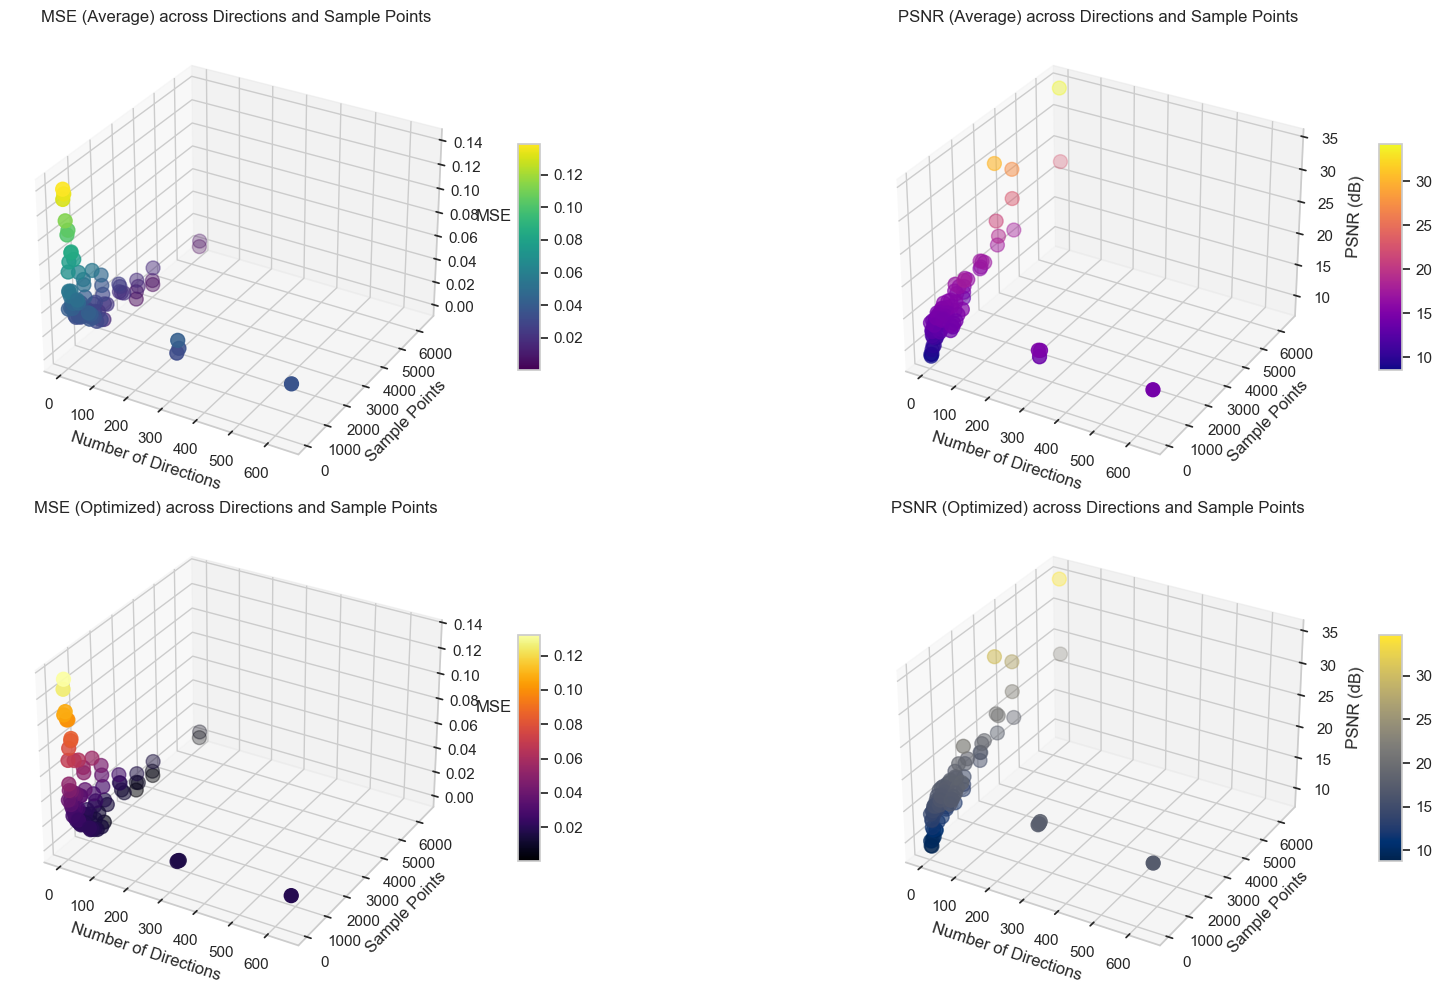

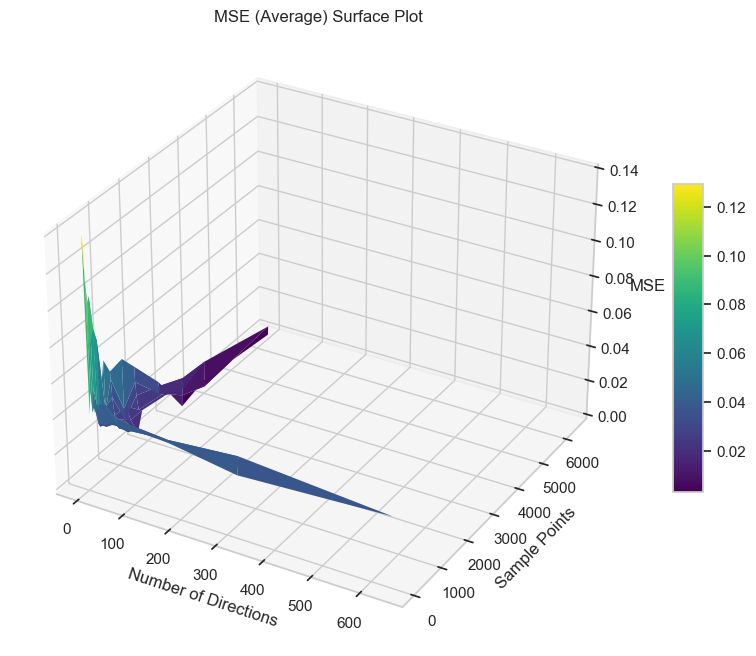

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image
import pandas as pd
import os
import pickle

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(
        original, reconstructed, data_range=original.max() - original.min()
    )
    return mse_value, psnr_value

# Load image
image_url = "1.jpg"  # Ensure '1.jpg' is in the current working directory
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

# Resize image to 256x256
image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((128, 128)))

# Display the original image
plt.figure(figsize=(6, 4))
if image_original.dtype in [np.float32, np.float64]:
    plt.imshow(image_original / 255.0)
else:
    plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Normalize image to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define auxiliary functions
def generate_random_directions(num_directions):
    # Generate the first random angle
    theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)

    # Compute angle increment
    delta_theta = 2 * np.pi / num_directions

    # Generate the angles starting from theta0
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0

    # Wrap angles back into [0, 2π)
    angles = angles % (2 * np.pi)

    # Compute directions
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py_grid, Px_grid = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px_flat = Px_grid.flatten()
    Py_flat = Py_grid.flatten()
    coordinates = calculate_coordinates(Px_flat, Py_flat, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Analysis parameters
num_directions_list = [1,2,4,8,16,32,64 ,320,640]  # Different number of directions to test
num_iterations_list = [5,10,15, 20,30, 40,60, 80,120, 160,240,320,400,640,960,1280]  # Different number of iterations to test
# num_directions_list = [50,100]  # Different number of directions to test
# num_iterations_list = [5,10]  # Different number of iterations to test
# Threshold to limit computational load
threshold = 51921

# 初始化列表以存储结果
results_list = []

# 循环遍历不同的组合
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # 生成随机方向
        if (num_directions+5) * (num_iterations*10) > threshold:
            print(f"Skipping: Directions={num_directions}, Iterations={num_iterations} (Threshold exceeded)")
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py_grid, Px_grid = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px_grid.flatten()
        Py = Py_grid.flatten()

        for t in tqdm(range(num_iterations), desc=f"Directions={num_directions}, Iter={num_iterations}"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_lerp(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

        # 重建预测图像（平均）
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # 评估指标
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)

        # 使用最小二乘法优化的预测图像
        # 为最小二乘问题采样一部分像素
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # 初始化X矩阵用于最小二乘法
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_lerp(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # 解决每个通道的最小二乘问题
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # 使用优化权重重建最终预测图像
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # 优化后的评估指标
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)

        # 差异图像（Optimized - Original）
        difference_image = np.abs(reconstructed2_opt - image)

        # 计算采样点数量
        sample_points = num_iterations * 10

        # 将结果添加到列表中
        results_list.append({
            'num_directions': num_directions,
            'sample_points': sample_points,
            'MSE_Average': mse2_avg,
            'PSNR_Average': psnr2_avg,
            'MSE_Optimized': mse2_opt,
            'PSNR_Optimized': psnr2_opt
        })

        # 打印进度
        print(f"Completed: Directions={num_directions}, Sample Points={sample_points}")

        # # 显示结果图像
        # fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # # 平均预测图像
        # avg_image_display = final_predicted_image_avg.cpu().numpy() / 255.0
        # axes[0].imshow(avg_image_display)
        # axes[0].set_title(f'Average Predicted Image (Directions={num_directions}, Sample Points={sample_points})\nPSNR: {psnr2_avg:.2f}dB, MSE: {mse2_avg:.6f}')
        # axes[0].axis('off')

        # # 优化预测图像
        # axes[1].imshow(reconstructed2_opt)
        # axes[1].set_title(f'Optimized Predicted Image (Directions={num_directions}, Sample Points={sample_points})\nPSNR: {psnr2_opt:.2f}dB, MSE: {mse2_opt:.6f}')
        # axes[1].axis('off')

        # # 差异图像
        # axes[2].imshow(difference_image, cmap='gray')
        # axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        # axes[2].set_title('Difference Image (Optimized - Original)')
        # axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        # 创建DataFrame
        results = pd.DataFrame(results_list)

        # 显示DataFrame
        # print(results)

        # 可选：将结果保存为CSV文件以供将来参考
        results.to_csv('reconstruction_results_compressed.csv', index=False)

# 创建DataFrame
results = pd.DataFrame(results_list)

# 显示DataFrame
print(results)

# 可选：将结果保存为CSV文件以供将来参考
results.to_csv('reconstruction_results.csv', index=False)

# 3D 散点图
fig = plt.figure(figsize=(20, 10))

# MSE (Average) 的3D散点图
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
scatter1 = ax1.scatter(
    results['num_directions'],
    results['sample_points'],
    results['MSE_Average'],
    c=results['MSE_Average'],
    cmap='viridis',
    s=100,
    depthshade=True
)
ax1.set_title('MSE (Average) across Directions and Sample Points')
ax1.set_xlabel('Number of Directions')
ax1.set_ylabel('Sample Points')
ax1.set_zlabel('MSE')
fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=10)

# PSNR (Average) 的3D散点图
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
scatter2 = ax2.scatter(
    results['num_directions'],
    results['sample_points'],
    results['PSNR_Average'],
    c=results['PSNR_Average'],
    cmap='plasma',
    s=100,
    depthshade=True
)
ax2.set_title('PSNR (Average) across Directions and Sample Points')
ax2.set_xlabel('Number of Directions')
ax2.set_ylabel('Sample Points')
ax2.set_zlabel('PSNR (dB)')
fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=10)

# MSE (Optimized) 的3D散点图
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
scatter3 = ax3.scatter(
    results['num_directions'],
    results['sample_points'],
    results['MSE_Optimized'],
    c=results['MSE_Optimized'],
    cmap='inferno',
    s=100,
    depthshade=True
)
ax3.set_title('MSE (Optimized) across Directions and Sample Points')
ax3.set_xlabel('Number of Directions')
ax3.set_ylabel('Sample Points')
ax3.set_zlabel('MSE')
fig.colorbar(scatter3, ax=ax3, shrink=0.5, aspect=10)

# PSNR (Optimized) 的3D散点图
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
scatter4 = ax4.scatter(
    results['num_directions'],
    results['sample_points'],
    results['PSNR_Optimized'],
    c=results['PSNR_Optimized'],
    cmap='cividis',
    s=100,
    depthshade=True
)
ax4.set_title('PSNR (Optimized) across Directions and Sample Points')
ax4.set_xlabel('Number of Directions')
ax4.set_ylabel('Sample Points')
ax4.set_zlabel('PSNR (dB)')
fig.colorbar(scatter4, ax=ax4, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

# 可选：3D 表面图示例（需要数据为完整网格）
# 这里假设您的 num_iterations 和 num_directions 组合形成了完整的网格
# 如果不是，请确保数据完整或进行适当的插值

# 创建透视表以适应表面图
pivot_table = results.pivot(index='sample_points', columns='num_directions', values='MSE_Average')

# 检查是否有缺失值
if pivot_table.isnull().values.any():
    print("Warning: Pivot table contains NaN values. Surface plot may be incomplete.")

# 创建网格
X = pivot_table.columns.values
Y = pivot_table.index.values
X, Y = np.meshgrid(X, Y)
Z = pivot_table.values

# 绘制MSE (Average) 的表面图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('MSE (Average) Surface Plot')
ax.set_xlabel('Number of Directions')
ax.set_ylabel('Sample Points')
ax.set_zlabel('MSE')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns


results['parameter_count'] = results['num_directions']  * results['sample_points']*4
results['parameter_count_compressed'] = results['sample_points']*5
# Set the plotting style
sns.set(style="whitegrid")

# Get sorted unique sample points for consistent coloring
sample_points = sorted(results['sample_points'].unique())

# Create a color palette
palette = sns.color_palette("hsv", len(sample_points))

# Plot 1: MSE_Average vs. Parameter Count
# plt.figure(figsize=(12, 8))

# for idx, samp_pt in enumerate(sample_points):
#     subset = results[results['sample_points'] == samp_pt]
#     subset = subset.sort_values('parameter_count')
#     plt.plot(
#         subset['parameter_count'],
#         subset['MSE_Average'],
#         marker='o',
#         label=f'Sample Points = {samp_pt}',
#         color=palette[idx]
#     )

# plt.xlabel('Number of Parameters (Directions  * Sample Points * 4)', fontsize=14)
# plt.ylabel('MSE (Mean Squared Error - Average)', fontsize=14)
# plt.title('Relationship Between Parameter Count and Average MSE', fontsize=16)
# plt.legend(title='Sample Points', fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot 2: MSE_Optimized vs. Parameter Count
# plt.figure(figsize=(12, 8))

# for idx, samp_pt in enumerate(sample_points):
#     subset = results[results['sample_points'] == samp_pt]
#     subset = subset.sort_values('parameter_count')
#     plt.plot(
#         subset['parameter_count'],
#         subset['MSE_Average'],
#         marker='o',
#         label=f'Sample Points = {samp_pt}',
#         color=palette[idx]
#     )

# plt.xlabel('Number of Parameters (Directions  * Sample Points * 4)', fontsize=14)
# plt.ylabel('MSE (Mean Squared Error - Average)', fontsize=14)
# plt.title('Relationship Between Parameter Count and Average MSE', fontsize=16)
# plt.legend(title='Sample Points', fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot 2: MSE_Optimized vs. Parameter Count
# plt.figure(figsize=(12, 8))

# for idx, samp_pt in enumerate(sample_points):
#     subset = results[results['sample_points'] == samp_pt]
#     subset = subset.sort_values('parameter_count')
#     plt.plot(
#         subset['parameter_count'],
#         subset['MSE_Optimized'],
#         marker='x',
#         label=f'Sample Points = {samp_pt}',
#         color=palette[idx]
#     )

# plt.xlabel('Number of Parameters (Directions  * Sample Points * 4)', fontsize=14)
# plt.ylabel('MSE (Mean Squared Error - Optimized)', fontsize=14)
# plt.title('Relationship Between Parameter Count and Optimized MSE', fontsize=16)
# plt.legend(title='Sample Points', fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# # Plot 1: MSE_Average vs. Parameter Count
# plt.figure(figsize=(12, 8))

# for idx, samp_pt in enumerate(sample_points):
#     subset = results[results['sample_points'] == samp_pt]
#     subset = subset.sort_values('parameter_count_compressed')
#     plt.plot(
#         subset['parameter_count_compressed'],
#         subset['MSE_Average'],
#         marker='o',
#         label=f'Sample Points = {samp_pt}',
#         color=palette[idx]
#     )

# plt.xlabel('Number of Parameters (Compressed)', fontsize=14)
# plt.ylabel('MSE (Mean Squared Error - Average)', fontsize=14)
# plt.title('Relationship Between Parameter Count and Average MSE', fontsize=16)
# plt.legend(title='Sample Points', fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot 2: MSE_Optimized vs. Parameter Count
# # Plot 2: MSE_Optimized vs. Parameter Count
# plt.figure(figsize=(12, 8))
# directions = sorted(results['num_directions'].unique())
# for idx, samp_d in enumerate(directions):
#     subset = results[results['num_directions'] == samp_d]
#     subset = subset.sort_values('parameter_count_compressed')
#     plt.plot(
#         subset['parameter_count_compressed'],
#         subset['MSE_Optimized'],
#         marker='x',
#         label=f'Directions = {samp_d}',
#         color=palette[idx]
#     )

# plt.xlabel('Number of Parameters (Compressed)', fontsize=14)
# plt.ylabel('MSE (Mean Squared Error - Optimized)', fontsize=14)
# plt.title('Relationship Between Parameter Count and Optimized MSE', fontsize=16)
# plt.legend(title='Sample Points', fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

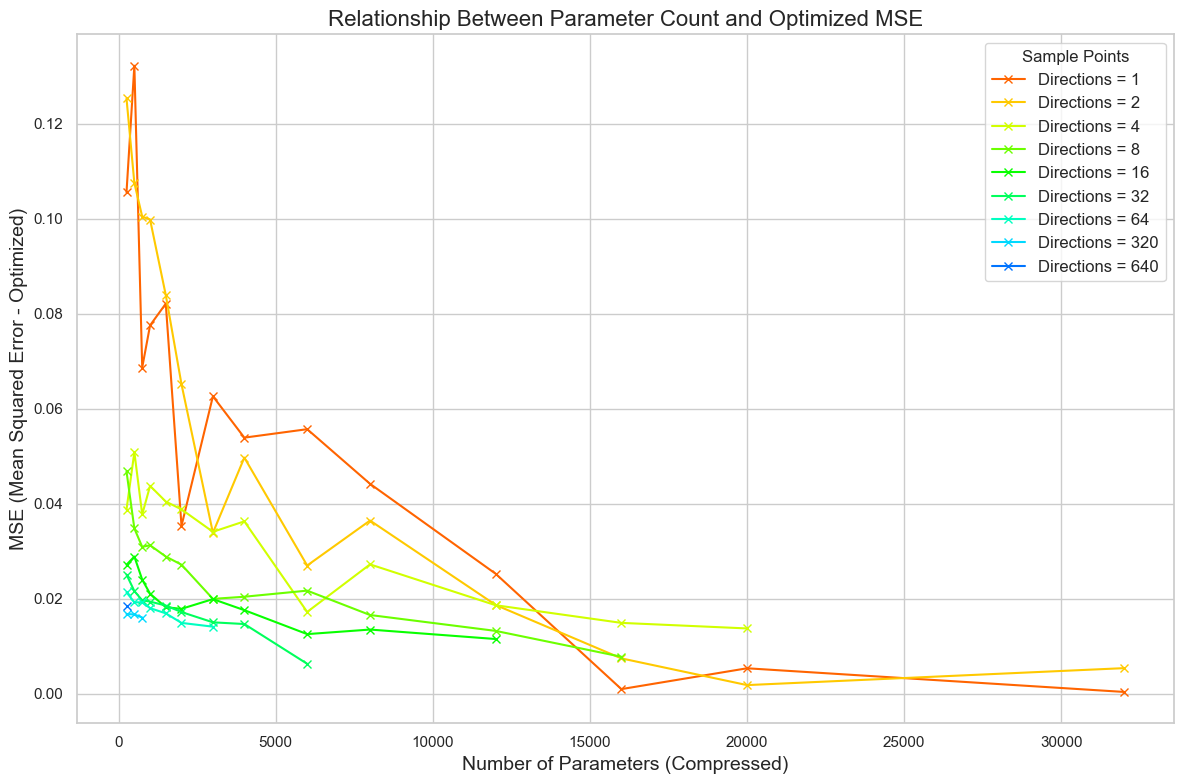

In [4]:


# Plot 2: MSE_Optimized vs. Parameter Count
# Plot 2: MSE_Optimized vs. Parameter Count
plt.figure(figsize=(12, 8))
directions = sorted(results['num_directions'].unique())
for idx, samp_d in enumerate(directions):
    subset = results[results['num_directions'] == samp_d]
    subset = subset.sort_values('parameter_count_compressed')
    plt.plot(
        subset['parameter_count_compressed'],
        subset['MSE_Optimized'],
        marker='x',
        label=f'Directions = {samp_d}',
        color=palette[idx]
    )

plt.xlabel('Number of Parameters (Compressed)', fontsize=14)
plt.ylabel('MSE (Mean Squared Error - Optimized)', fontsize=14)
plt.title('Relationship Between Parameter Count and Optimized MSE', fontsize=16)
plt.legend(title='Sample Points', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Device in use: cuda
Original image shape: (1024, 1024, 3) Type: uint8


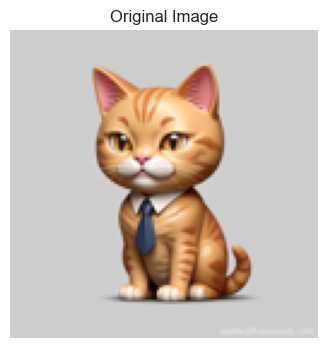

Directions=4, Iter=880: 100%|██████████| 880/880 [00:11<00:00, 77.09it/s]


Completed: Directions=4, Sample Points=8800


Directions=64, Iter=880: 100%|██████████| 880/880 [02:47<00:00,  5.25it/s]


Completed: Directions=64, Sample Points=8800


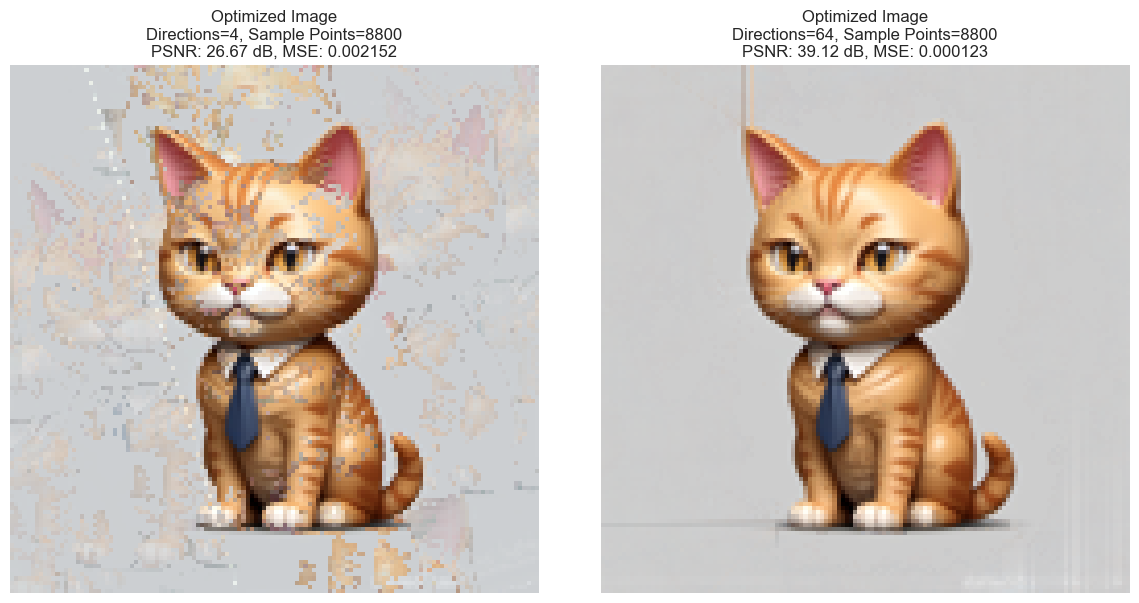

   num_directions  sample_points  MSE_Optimized  PSNR_Optimized
0               4           8800       0.002152       26.671884
1              64           8800       0.000123       39.116913


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image
import pandas as pd
import os
import pickle

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# 定义计算MSE和PSNR的函数
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(
        original, reconstructed, data_range=original.max() - original.min()
    )
    return mse_value, psnr_value

# 加载图像
image_url = "1.jpg"  # 确保 '1.jpg' 在当前工作目录中
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

# 调整图像大小到128x128
image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((128, 128)))

# 显示原始图像
plt.figure(figsize=(6, 4))
if image_original.dtype in [np.float32, np.float64]:
    plt.imshow(image_original / 255.0)
else:
    plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# 归一化图像到[0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# 定义辅助函数
def generate_random_directions(num_directions):
    theta0 = torch.rand(1, device=device) * 2 * np.pi
    delta_theta = 2 * np.pi / num_directions
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0
    angles = angles % (2 * np.pi)
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves

def predict_image(curves, dx, dy, width, height):
    Py_grid, Px_grid = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px_flat = Px_grid.flatten()
    Py_flat = Py_grid.flatten()
    coordinates = calculate_coordinates(Px_flat, Py_flat, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)
    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]
    weight = (x - x0) / (x1 - x0 + 1e-8)  # 避免除以零
    return torch.lerp(y0, y1, weight)

# 分析参数
num_directions_list = [4, 64]  # 仅处理4和64方向
num_iterations_list = [880]    # 迭代次数
threshold = 5192199

# 初始化字典以存储不同方向数的优化图像
comparison_results = {
    4: {},
    64: {}
}

# 循环遍历不同的组合
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # 检查阈值
        if (num_directions + 5) * (num_iterations * 10) > threshold:
            print(f"Skipping: Directions={num_directions}, Iterations={num_iterations} (Threshold exceeded)")
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py_grid, Px_grid = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px_grid.flatten()
        Py = Py_grid.flatten()

        for t in tqdm(range(num_iterations), desc=f"Directions={num_directions}, Iter={num_iterations}"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_lerp(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

        # 重建优化预测图像
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # 使用最小二乘法优化的预测图像
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # 初始化X矩阵用于最小二乘法
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_lerp(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # 解决每个通道的最小二乘问题
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # 使用优化权重重建最终预测图像
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # 优化后的评估指标
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)

        # 将结果添加到比较字典中
        comparison_results[num_directions]['optimized'] = reconstructed2_opt
        comparison_results[num_directions]['sample_points'] = num_iterations * 10
        comparison_results[num_directions]['MSE_Optimized'] = mse2_opt
        comparison_results[num_directions]['PSNR_Optimized'] = psnr2_opt

        # 打印进度
        print(f"Completed: Directions={num_directions}, Sample Points={comparison_results[num_directions]['sample_points']}")

# 创建并排对比优化后的图像
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, num_directions in enumerate(num_directions_list):
    data = comparison_results[num_directions]
    
    # 优化预测图像
    axes[idx].imshow(data['optimized'])
    axes[idx].set_title(
        f'Optimized Image\nDirections={num_directions}, Sample Points={data["sample_points"]}\nPSNR: {data["PSNR_Optimized"]:.2f} dB, MSE: {data["MSE_Optimized"]:.6f}'
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 创建DataFrame并保存结果
results_df = pd.DataFrame([
    {
        'num_directions': num_directions,
        'sample_points': data['sample_points'],
        'MSE_Optimized': data['MSE_Optimized'],
        'PSNR_Optimized': data['PSNR_Optimized']
    }
    for num_directions, data in comparison_results.items()
])

print(results_df)
